# Code Breakfast : Fairness in Machine Learning

Fairness is a socio-techno problem.
In the code breakfast, we will discuss the following topics:
1. What is fairness?
2. Why is fairness important?
3. How to measure fairness/bias for your specific problem?
    * Look at the decision tree and choosing the right metric
    * Calculating that metric. 
4. How to mitigate bias?
    * Pre-processing
    * In-processing
    * Post-processing
5. MV views on fairness.   



In [ ]:
#!pip install aequitas==0.42.0
#!pip install pandas==1.4.4
#!pip install fairlearn
#!pip install xgboost
#!pip install sklearn
#!pip install matplotlib
#!pip install seaborn
#!pip install numpy
#!pip install probatus==2.0.0

### Pre-process data

In [ ]:
df = read_csv_data('../data/german_credit_data.csv')
df = apply_transformation(df)
df.drop('index', axis=1, inplace=True)
df['credit_risk'].value_counts(normalize=True)

### Train a ML model

In [28]:
keep_cols = ['status', 'credit_history', 'amount','savings', 
             'employment_duration', 'installment_rate', 
             'isMale','age', 'isForeignWorker', 
             'credit_risk']
model,data_dict = train_test_xgb(df,'credit_risk',keep_cols=keep_cols,tune=False)
data_dict['results'].head()

Train set ROC-AUC: 0.8297226782363977
CV ROC-AUC: 0.7527363342400161
Test set ROC-AUC: 0.7793426003344482


,status,credit_history,amount,savings,employment_duration,installment_rate,isMale,age,isForeignWorker,label_value,y_pred,score
521,4,2,10974,1,1,4,0,26,0,1,0.804531,1
737,4,4,1149,4,3,4,1,46,0,0,0.050735,0
740,4,2,1736,1,4,3,0,31,0,0,0.071115,0
660,2,2,1414,1,3,4,1,33,1,0,0.281545,1
411,4,3,2978,5,3,4,1,32,0,0,0.063285,0


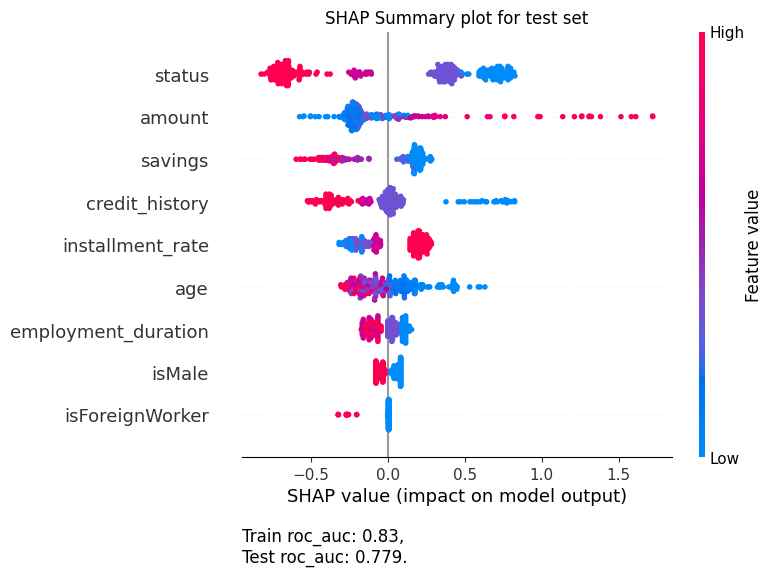

In [29]:
shap_interpreter = ShapModelInterpreter(model)
feature_importance = shap_interpreter.fit_compute(data_dict['xtrain'], data_dict['xtest'], data_dict['ytrain'], data_dict['ytest'], approximate=False)
ax = shap_interpreter.plot('summary')

## 2. Fairness - Evaluation
### 1. What Fairness Metrics should I care about ?

There is no one-size-fits-all fairness metric. It depends on the context and the problem you are trying to solve.
However the following tree can help you choose the right metric for your problem.

![Fairness Tree](../img/fairness_tree.png)

In the context of credit scoring, the intervention would result in denial of credit.
That (let us assume) is a punitive action. So we would consider two metrics:

1. False Discovery Rate Parity :
Achieving FDR parity in a credit risk model would involve ensuring that the FDR is roughly equal across different demographic groups. This means that the rate of falsely identified high-risk applications should be comparable, regardless of an applicant's membership in a specific group.

2. False Posivite Rate Parity  : False positive rate parity, in the context of fairness, refers to the principle of ensuring equal false positive rates across different groups or demographics when using predictive models or algorithms.
False positive rate parity focuses specifically on the rate at which individuals from different groups are incorrectly flagged as positive (e.g., being labeled as high-risk or having a certain condition) when they should have been classified as negative.
False positive rate parity would require that the model's false positive rate (the rate at which it incorrectly predicts someone as high risk when they would not actually default) is roughly equal for different demographic groups. This ensures that individuals are not disproportionately disadvantaged by being falsely labeled as high risk and potentially denied loans or opportunities.

By striving for false positive rate parity, organizations aim to reduce the potential for discriminatory outcomes and ensure that individuals are treated fairly and equitably, regardless of their demographic characteristics. It is one of several metrics and considerations used to assess algorithmic fairness and mitigate bias in decision-making systems.

For this we will use the `aquetas` library.


In [30]:
#Convert the columns in results to an understandable format.
results = data_dict['results']
gender_dict = {1:"M",0:"F"}
fworker_dict = {1:"Y",0:"N"}
# Apply the dictionaries to the columns.
results['isMale'] = results['isMale'].map(gender_dict)
results['isForeignWorker'] = results['isForeignWorker'].map(fworker_dict)
attributes_and_reference_groups={'isMale':'M', 'isForeignWorker':'Y'}
attributes_to_audit = list(attributes_and_reference_groups.keys())
metrics = ['fpr']
disparity_tolerance = 1.20

In [31]:
# Initialize Aequitas
g = Group()
b = Bias()
# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(results, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=results, ref_groups_dict=attributes_and_reference_groups)

get_disparity_predefined_group()


In [32]:
ap.disparity(bdf, metrics, 'isMale', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [33]:
ap.disparity(bdf, metrics, 'isForeignWorker', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

## 2. Fairness- Mitigation

 Assumption : We don't use the protected attribute in the model, so my model is fair.
 
 Let us check if that is true.Train a model to predict protected attributes.
 If we get a better than random roc-auc score, then we know that some of the other model features are correlated with protected attributes.


Train set ROC-AUC: 0.7971372804163956
CV ROC-AUC: 0.7219889092256396
Test set ROC-AUC: 0.753369755049035


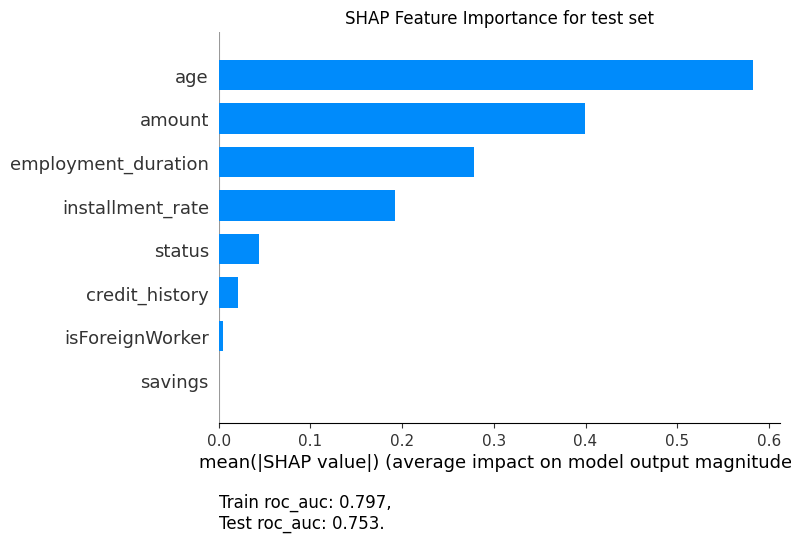

In [34]:
#Drop column credit_risk
keep_cols = ['status', 'credit_history', 'amount',
       'savings', 'employment_duration', 'installment_rate','age','isMale','isForeignWorker']

gender_model,data_dict = train_test_xgb(df.drop('credit_risk',axis=1),'isMale',keep_cols=keep_cols,tune=False)
shap_interpreter = ShapModelInterpreter(gender_model)
feature_importance = shap_interpreter.fit_compute(data_dict['xtrain'], 
                                                  data_dict['xtest'], 
                                                  data_dict['ytrain'], 
                                                  data_dict['ytest'], 
                                                  approximate=False)
ax = shap_interpreter.plot('importance')

This shows us that the model is able to predict the protected attribute, that some of the other features are correlated with the protected attribute.
Is there a way to remove these co-relations without losing too much accuracy?

Lets try to do that with the help of `sklearn-lego` package.

In [ ]:
from sklego.preprocessing import InformationFilter
y = df['credit_risk']
x = df.drop('credit_risk',axis=1)
x_fair = InformationFilter(["isMale", "isForeignWorker"]).fit_transform(x)
x_fair = pd.DataFrame(x_fair,
                      columns=[n for n in x.columns if n not in ["isMale", "isForeignWorker"]])
x_fair['credit_risk'] = y

In [ ]:
keep_cols = ['status', 'credit_history', 'amount',
       'savings', 'employment_duration', 'installment_rate','age','credit_risk']

fair_model,data_dict = train_test_xgb(x_fair,'credit_risk',keep_cols=keep_cols,tune=False)
shap_interpreter = ShapModelInterpreter(fair_model)
feature_importance = shap_interpreter.fit_compute(data_dict['xtrain'],
                                                data_dict['xtest'], 
                                                data_dict['ytrain'], 
                                                data_dict['ytest'], 
                                                approximate=False)
ax = shap_interpreter.plot('summary')

  Using cached fairlearn-0.8.0-py3-none-any.whl (235 kB)
